In [11]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier,StackingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score,roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC,LinearSVC
from sklearn.feature_selection import SelectKBest,f_classif,SelectFromModel,RFE
from skopt import BayesSearchCV
import copy
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")


In [2]:
X_train = pd.read_csv("C:\\Users\\User\\Desktop\\Python_5sem\\artifical_train_data.csv")
y_train = pd.read_csv("C:\\Users\\User\\Desktop\\Python_5sem\\artifical_train_labels.csv")
X_test = pd.read_csv("C:\\Users\\User\\Desktop\\Python_5sem\\artifical_test_data.csv")
X_train.describe()
X_train.dtypes
values, counts = np.unique(X_train, return_counts=True)
values, counts = np.unique(y_train, return_counts=True)
values,counts

(array([-1,  1], dtype=int64), array([1000, 1000], dtype=int64))

In [3]:
X_train.isnull().values.any()
X_test.shape
X_test.isnull().values.any()
df = copy.deepcopy(X_train)
df["Target"] = y_train
# nie ma braków danych.

<AxesSubplot:>

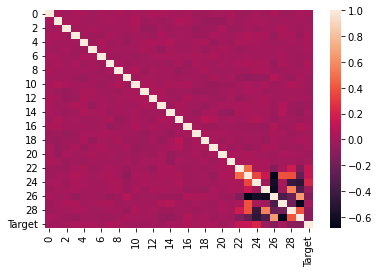

In [4]:

corr_matrix = X_train.corr()
corr_matrix_y = df.corr()
sns.heatmap(corr_matrix_y)

In [5]:
# kolumny są generalnie niezbyt skorelowane (liniowo) z wyjatkiem kolumn 22-30 które są między sobą trochę skorelowane.

In [105]:
# Wybór zmiennych, usuwanie niepotrzebnych kolumn

# 1 metoda; SelectKBest
selector = SelectKBest(f_classif, k=8)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
cols_idxs
feature_scores = selector.scores_
feature_scores = feature_scores.tolist()
feature_scores = [[feature_scores[i],i] for i in range(len(feature_scores))]
feature_scores.sort(key=lambda x: x[0])
feature_scores
# Dosyć duże wagi otrzymały kolumny o indeksach 25,16,28,29,22,26,23,24
#cols_idxs

[[0.01979356721070401, 6],
 [0.053370951288079886, 0],
 [0.07553879764135057, 15],
 [0.10226358393753376, 12],
 [0.1124205422259906, 21],
 [0.12154072013988332, 9],
 [0.12300117196158064, 2],
 [0.1342236081944806, 1],
 [0.15714362664118983, 10],
 [0.22099312445982316, 14],
 [0.2689230923427067, 27],
 [0.2846030181797045, 17],
 [0.5166845758504978, 20],
 [0.5269311464552834, 5],
 [0.5617457200953673, 11],
 [0.5726699152677863, 13],
 [0.6450821615612872, 8],
 [0.648938090647064, 19],
 [1.0416201485451713, 4],
 [1.2985358355936263, 18],
 [1.5012283056660913, 3],
 [2.222215430244578, 7],
 [2.2629535046543525, 25],
 [2.6737677191349514, 16],
 [18.40568742680988, 28],
 [25.413854374545473, 29],
 [28.444776244599286, 22],
 [30.081219012422455, 26],
 [32.62703615805269, 23],
 [99.52426895317825, 24]]

In [6]:
# 2 metoda; PCA (z 5 głównymi zmiennymi)
components = PCA(n_components=8)
components = components.fit(X_train,y_train)
features = []
for i in components.components_:
    j = i.tolist()
    j = [[j[k],k] for k in range(len(j))]
    j.sort(key=lambda x: x[0])
    j = j[-3:]
    features.append(j)
features    
# Ciężko jednoznacznie wyznaczyć które zmienne są ważne...


[[[0.024316252753328615, 9],
  [0.06778254853489024, 24],
  [0.44956723516289077, 26]],
 [[0.35000274175336155, 29],
  [0.40313210389884496, 28],
  [0.7207027786776663, 26]],
 [[0.02625320599557526, 5], [0.3501361676812464, 25], [0.5672182561617424, 9]],
 [[0.08091090270416246, 24],
  [0.1440514444886069, 29],
  [0.16247254765938082, 0]],
 [[0.018176320018120112, 5],
  [0.021372183403034224, 18],
  [0.05025029182830487, 20]],
 [[0.21414890019632957, 24],
  [0.3333166036881336, 9],
  [0.5925335950948933, 20]],
 [[0.34947694718694045, 25],
  [0.37027056317633955, 3],
  [0.5545180851273269, 20]],
 [[0.0763113976196882, 0],
  [0.30464191029325327, 14],
  [0.44732035000469755, 20]]]

In [7]:
# 3 metoda; RFE z użyciem RandomForestClassifier
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100,min_samples_leaf=150,max_leaf_nodes=50),n_features_to_select=30)
rfe = rfe.fit(X_train,y_train)
feature_scores_rfe = rfe.estimator_.feature_importances_
feature_scores_rfe = feature_scores_rfe.tolist()
feature_scores_rfe = [[feature_scores_rfe[i],i] for i in range(len(feature_scores_rfe))]
feature_scores_rfe.sort(key=lambda x: x[0])
feature_scores_rfe
# jak widać, top 8 zmiennych ( i to ze sporą wagą) według rfe to kolumny: 24,26,25,29,22,28,23,27. Zdecydowałem się na więc na ich użycie do dalszej pracy

[[0.001401548837383145, 12],
 [0.0019267765394814763, 18],
 [0.003338242145083017, 14],
 [0.0033419786569532377, 0],
 [0.003646536049001333, 13],
 [0.004033303038105575, 8],
 [0.004295682368314949, 17],
 [0.004305399354968767, 6],
 [0.004386662344902905, 15],
 [0.004429315935973117, 21],
 [0.004916114042673999, 16],
 [0.00507127553111643, 9],
 [0.005193884397176867, 11],
 [0.005724896186873433, 10],
 [0.006073586681041621, 20],
 [0.0065483400242971005, 2],
 [0.00706314985571844, 5],
 [0.007691997649508198, 19],
 [0.00813429566968532, 1],
 [0.008810349528335962, 4],
 [0.008957555916572916, 7],
 [0.009223809178582842, 3],
 [0.04060898696382817, 27],
 [0.06579523301789492, 25],
 [0.0719043912006116, 29],
 [0.07503070734871634, 22],
 [0.08549596282283511, 23],
 [0.08635685677729234, 28],
 [0.2155436810649418, 26],
 [0.24074948087212908, 24]]

In [3]:
X_train_8 = X_train.iloc[:,[22,23,24,25,26,27,28,29]]
X_test_8 = X_test.iloc[:,[22,23,24,25,26,27,28,29]]

In [10]:

# Modele:
# Próba z RandomForest, niestety niezbyt udana. Możliwość dopasowania metody do zbioru danych wyznaczałem za pomocą zagnieżdżonej kroswalidacji.

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=6, shuffle=True, random_state=2)
space = dict()
space['rf__n_estimators'] = list(range(50,300,50))
space['rf__min_samples_leaf'] = list(range(50,200,25)) #(50,200,25)
space['rf__max_depth'] = list(range(10,60,10))       # (10,60,10)
space['rf__max_leaf_nodes'] = list(range(10,200,10))
search = RandomizedSearchCV(pipeline_rf, space, scoring='balanced_accuracy', n_jobs=1, cv=cv_inner,n_iter = 100,refit=True)
scores_rf = cross_val_score(search, X_train_8, y_train, scoring='balanced_accuracy', cv=cv_outer, n_jobs=-1)
scores__rf = cross_validate(search, X_train_8, y_train, cv=cv_outer, n_jobs=-1,return_estimator=True)
parameters = []
for j in range(6):
    parameters.append(scores__rf['estimator'][j].best_params_)
scores_rf,parameters
# do dalszej pracy w razie czego wezmę randomforest z parametrami: n_estimators = 100, min_samples_leaf = 100,max_leaf_nodes = 50,max_depth = 20, zeby zapobiec overfitowaniu


(array([0.73989499, 0.71968498, 0.71452276, 0.71849924, 0.77487194,
        0.73877684]),
 [{'rf__n_estimators': 100,
   'rf__min_samples_leaf': 50,
   'rf__max_leaf_nodes': 30,
   'rf__max_depth': 20},
  {'rf__n_estimators': 100,
   'rf__min_samples_leaf': 50,
   'rf__max_leaf_nodes': 160,
   'rf__max_depth': 50},
  {'rf__n_estimators': 50,
   'rf__min_samples_leaf': 50,
   'rf__max_leaf_nodes': 30,
   'rf__max_depth': 40},
  {'rf__n_estimators': 100,
   'rf__min_samples_leaf': 50,
   'rf__max_leaf_nodes': 120,
   'rf__max_depth': 50},
  {'rf__n_estimators': 150,
   'rf__min_samples_leaf': 50,
   'rf__max_leaf_nodes': 170,
   'rf__max_depth': 40},
  {'rf__n_estimators': 150,
   'rf__min_samples_leaf': 50,
   'rf__max_leaf_nodes': 120,
   'rf__max_depth': 30}])

In [56]:
# Metoda ExtraTrees, również z niezbyt dobrym skutkiem
pipeline_extra = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', ExtraTreesClassifier())
])
cv_inner = KFold(n_splits=6, shuffle=True, random_state=1)
space = dict()
space['rf__n_estimators'] = list(range(50,300,50)) 
space['rf__min_samples_leaf'] = list(range(50,200,25)) 
space['rf__max_depth'] = list(range(10,60,10))      
space['rf__max_leaf_nodes'] = list(range(10,200,10))

search = RandomizedSearchCV(pipeline_extra, space, scoring='balanced_accuracy', n_jobs=1, cv=cv_inner, refit=True, n_iter = 150)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X_train_8, y_train, scoring='balanced_accuracy', cv=cv_outer, n_jobs=-1)
scores

array([0.67878788, 0.73989899, 0.67451745, 0.70572057, 0.63918199,
       0.67356943, 0.64432367, 0.70908818, 0.66266026, 0.64375   ])

In [82]:
# Gradient Boosting, z w miarę ciekawymi wynikami, do niego jeszcze wrócimy
pipeline_gradientboosting = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', GradientBoostingClassifier(n_estimators=250,min_samples_leaf=50,max_leaf_nodes=50,max_depth=40))
])
scores = cross_val_score(
pipeline_gradientboosting, X_train_8, y_train, cv=10, scoring='balanced_accuracy')
scores

array([0.875, 0.87 , 0.9  , 0.865, 0.83 , 0.865, 0.87 , 0.8  , 0.855,
       0.82 ])

In [77]:
# Stacking, żeby przyspieszyć robię kilka razy wykonuję ten kod kilka razy, zeby train_test_split wylosowal dostatecznie rozne podziały
clf1 = BaggingClassifier(KNeighborsClassifier(n_neighbors=3),n_estimators=50)
clf4 = ExtraTreesClassifier(n_estimators=50,min_samples_leaf=100,max_leaf_nodes=100,max_depth=20)
clf5 = GradientBoostingClassifier(n_estimators=100,min_samples_leaf=100,max_leaf_nodes=100,max_depth=20)
X_train_train,X_train_test,y_train_train,y_train_test = train_test_split(X_train_8,y_train, test_size = 0.3)
pipeline_ensembels = Pipeline([
    ('scaler', StandardScaler()),
    ('eclf', StackingClassifier(estimators=[('lr', clf1),
                             ('extra',clf4),
                             ('boost', clf5)],final_estimator = RandomForestClassifier(n_estimators=100, min_samples_leaf=100,max_leaf_nodes=50,max_depth = 20), cv = 5,stack_method="predict_proba"))
])
pipeline_ensembels.fit(X_train_train,y_train_train)
scores_vote = pipeline_ensembels.score(X_train_test,y_train_test)
scores_vote
# Stacking radzi sobie naprawdę dobrze, (jest nadzieja na licencjat hah)

0.885

In [81]:
# Voting, ponownie połączony ze splitem
clf2 = RandomForestClassifier(n_estimators=100,min_samples_leaf=100,max_depth = 20,max_leaf_nodes=50)
clf5 = BaggingClassifier(KNeighborsClassifier(n_neighbors=6),n_estimators=100)
#clf6 = AdaBoostClassifier()
clf7 = BaggingClassifier(KNeighborsClassifier(n_neighbors=3),n_estimators=100)
X_train_train, X_train_test,y_train_train,y_train_test = train_test_split(X_train_8,y_train,test_size=0.3)
pipeline_vote = Pipeline([
    ('scaler', StandardScaler()),
    ('eclf', VotingClassifier(estimators=[
                             ('gb',clf5),
#                             ('rf',clf2),
                             ('Bknn',clf7)],voting = "soft"))
])
pipeline_vote.fit(X_train_train,y_train_train)
preds_vote = pipeline_vote.predict(X_train_test)
balanced_accuracy_score(preds_vote,y_train_test)
# Voting radzi sobie bardzo dobrze.

0.8648364836483649

In [64]:
preds_voting = preds_vote.tolist()
preds_bruh_vote = [i[1] for i in preds_voting]
file = open('C:\\Users\\User\\Desktop\\preds_vote.txt','w')
for item in preds_bruh_vote:
	file.write("%s\n" % str(item))
file.close()

In [15]:
# Gradient Boosting, z zagnieżdżoną kroswalidacją
pipeline_gradientboosting_op = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', GradientBoostingClassifier())
])
cv_inner = KFold(n_splits=6, shuffle=True, random_state=1)
space = dict()
space['rf__n_estimators'] = list(range(50,300,50)) #(50,300,50)
space['rf__min_samples_leaf'] = list(range(100,200,25)) #(50,200,25)
space['rf__max_depth'] = list(range(10,60,10))       # (10,60,10)
space['rf__max_leaf_nodes'] = list(range(10,130,10)) # (10,200,10)
search = RandomizedSearchCV(pipeline_gradientboosting_op, space, scoring='balanced_accuracy', n_jobs=1, cv=cv_inner, refit=True, n_iter = 250)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X_train_8, y_train, scoring='balanced_accuracy', cv=cv_outer, n_jobs=-1)
scores

array([0.83585859, 0.8479798 , 0.839984  , 0.83008301, 0.83991559,
       0.83053221, 0.84198873, 0.86622961, 0.85496795, 0.81875   ])

In [ ]:
# Gradient Boosting poradził sobie całkiem dobrze

In [88]:

pipeline_gradientboosting_op = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', GradientBoostingClassifier())
])
space = dict()
space['rf__n_estimators'] = list(range(50,300,50)) #(50,300,50)
space['rf__min_samples_leaf'] = list(range(50,200,25)) #(50,200,25)
space['rf__max_depth'] = list(range(10,60,10))       # (10,60,10)
space['rf__max_leaf_nodes'] = list(range(10,200,10)) # (10,200,10)
#X_train_train, X_train_test,y_train_train,y_train_test = train_test_split(X_train_8,y_train,test_size=0.3)
search = RandomizedSearchCV(pipeline_gradientboosting_op, space, scoring='balanced_accuracy', n_jobs=1, cv=10, n_iter = 250)
search.fit(X_train_8,y_train)
preds = search.predict_proba(X_test_8)
#search.best_params_
#balanced_accuracy_score(preds,y_train_test)



ValueError: X has 30 features, but StandardScaler is expecting 8 features as input.

In [89]:
preds = search.predict_proba(X_test_8)
preds
# Najlepsze parametry dla Gradient Boosting to; n_estimators = 200, min_samples_leaf = 50, max_leaf_nodes = 40, max_depth = 40 

array([[0.96904768, 0.03095232],
       [0.99029107, 0.00970893],
       [0.58421034, 0.41578966],
       ...,
       [0.03693748, 0.96306252],
       [0.02676968, 0.97323032],
       [0.99544387, 0.00455613]])

In [90]:
preds_bruh = preds.tolist()
preds_bruh_1 = [i[1] for i in preds_bruh]
#file = open('preds1.txt','w')
#for item in preds_bruh:
#	file.write(item+"\n")
#file.close()
preds_bruh
#pd.DataFrame(preds, columns=search.classes_)
preds_bruh_1
file = open('C:\\Users\\User\\Desktop\\preds\\preds_gb_nwm.txt','w')
for item in preds_bruh_1:
	file.write("%s\n" % str(item))
file.close()

In [91]:
search.best_params_
# Wypisane parametry Gradient Boosting

{'rf__n_estimators': 200,
 'rf__min_samples_leaf': 50,
 'rf__max_leaf_nodes': 40,
 'rf__max_depth': 20}

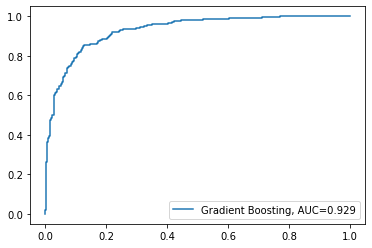

In [14]:
pipeline_gradientboosting_op = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', GradientBoostingClassifier(n_estimators=200,min_samples_leaf=50,max_leaf_nodes=40,max_depth=20))
])
X_train_train, X_train_test,y_train_train,y_train_test = train_test_split(X_train_8,y_train,test_size=0.3)
pipeline_gradientboosting_op.fit(X_train_train,y_train_train)
preds_split = pipeline_gradientboosting_op.predict_proba(X_train_test)
fpr, tpr, thresholds = roc_curve(y_train_test, preds_split[:,1])
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(round(roc_auc_score(y_train_test, preds_split[:,1]), 4)))
plt.legend()
plt.show()
#scores = cross_val_score(pipeline_gradientboosting_op, X_train_8, y_train, scoring='balanced_accuracy', cv=10, n_jobs=-1)
#scores

In [100]:
# Postanowiłem połączyć dwa najlepsze klasyfikatory jakie mam: Gradient Boosting oraz Bagging(KNN) w VotingClassifier, parametry dla GB podane wyżej, dla Bagging(Knn) to n_estimators = 100, n_neighbors = 3
# Jednakże okazało się, że sam chociaż Gradient Boosting ma odrobinę słabsze wyniki w porównaniu do Bagging(Knn) to jednak na próbce testowej (na stronie) Gradient Boosting odniósł lepszy wynik.
clf2 = GradientBoostingClassifier(n_estimators=200,min_samples_leaf=50,max_depth = 20,max_leaf_nodes=40)
clf5 = BaggingClassifier(KNeighborsClassifier(n_neighbors=3),n_estimators=100)
X_train_train, X_train_test,y_train_train,y_train_test = train_test_split(X_train_8,y_train,test_size=0.3)
pipeline_vote = Pipeline([
    ('scaler', StandardScaler()),
    ('eclf', VotingClassifier(estimators=[
                             ('gb',clf2),
                             ('Bknn',clf5)],voting = "soft"))
])
pipeline_vote.fit(X_train_train,y_train_train)
preds_vote_gb_knn = pipeline_vote.predict(X_train_test)
balanced_accuracy_score(preds_vote_gb_knn,y_train_test)

0.895

In [101]:
pipeline_vote = Pipeline([
    ('scaler', StandardScaler()),
    ('eclf', VotingClassifier(estimators=[
                             ('gb',clf2),
                             ('Bknn',clf5)],voting = "soft"))
])
pipeline_vote.fit(X_train_8,y_train)
preds_vote_gb_knn = pipeline_vote.predict_proba(X_test_8)

In [102]:
preds_bruh_knn_8 = preds_vote_gb_knn.tolist()
preds_bruh_knn_8_2 = [i[1] for i in preds_bruh_knn_8]
#file = open('preds1.txt','w')
#for item in preds_bruh:
#	file.write(item+"\n")
#file.close()
#preds_bruh
#pd.DataFrame(preds, columns=search.classes_)
#preds_bruh_1
file = open('C:\\Users\\User\\Desktop\\preds\\preds_vote_gb_knn.txt','w')
for item in preds_bruh_knn_8_2:
	file.write("%s\n" % str(item))
file.close()

In [8]:
# Próba z xgboostem, okazał się podobnie skuteczny co sklearnowy Gradient Boost
from xgboost import XGBClassifier

In [9]:
# XGBOOST
Y = copy.deepcopy(y_train)
Y[Y == -1] = 0
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train_8, Y, test_size=0.3)
model = XGBClassifier()
model.fit(X_train_train, y_train_train)
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100

preds_xgboost = model.predict(X_train_test)
balanced_accuracy_score(preds_xgboost,y_train_test)

0.8392857142857142

In [30]:
# Svm zbyt dobrze sobie nie poradził
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])
# define search space
space = dict()
space['svm__C'] = [0.001,0.005,0.01,0.05,0.1,0.5,1]
space['svm__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
cv_inner = KFold(n_splits=6, shuffle=True, random_state=1)
search = GridSearchCV(pipeline_svm, space, scoring='balanced_accuracy', n_jobs=1, cv=cv_inner,refit=True)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X_train, y_train, scoring='balanced_accuracy', cv=cv_outer, n_jobs=-1)
scores

array([0.63383838, 0.73838384, 0.63461346, 0.65046505, 0.66978193,
       0.68197279, 0.59621578, 0.68786908, 0.70713141, 0.63125   ])

In [20]:
search.best_params_

{'svm__C': 0.01, 'svm__kernel': 'linear'}

In [87]:
# Testowanie Bagging Classifier, ponownie ze splitem, z uwagi na problemy z funkcją BaggingClassifier, optymalizację hiperparametrów prowadziłem ręcznie, testując różne
# kombinacje parametru n_estimators i n_neighbors, wykonując dla każdej kombinacji wielokrotnie train_test_split na X_train
# Optymalna para to: n_neighbors = 3, n_estimators = 100
a = []
for i in range(10):
    X_train_train,X_train_test,y_train_train,y_train_test = train_test_split(X_train_8,y_train, test_size = 0.3,random_state = i+20)
    pipeline_b = Pipeline([
        ("scaler", StandardScaler()),
        ('bknn', BaggingClassifier(KNeighborsClassifier(n_neighbors=3),n_estimators=100))
    ])
    pipeline_b.fit(X_train_train,y_train_train)
    preds_knn = pipeline_b.predict(X_train_test)
    a.append(balanced_accuracy_score(preds_knn,y_train_test))
a

[0.8985152916073968,
 0.8850153890598784,
 0.8968176363393929,
 0.8888299001911233,
 0.9001956947162426,
 0.8867605696434726,
 0.8786607390941928,
 0.903901830653423,
 0.8828091100257012,
 0.9026696329254728]

In [59]:

pipeline_b = Pipeline([
    ("scaler", StandardScaler()),
    ('bknn', BaggingClassifier(KNeighborsClassifier(n_neighbors=3),n_estimators=100)) # 3, 100
])
space = dict()
space['bknn__estimator__n_neighbors'] = [3,4,5,6]
space['bknn__n_estimators'] = [50,100,150]
#search = GridSearchCV(pipeline_b,space,scoring = "balanced_accuracy",cv = 5)
pipeline_b.fit(X_train_8,y_train)
preds_knn = pipeline_b.predict_proba(X_test_8)
preds_knn


array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.36      , 0.64      ],
       ...,
       [0.        , 1.        ],
       [0.00333333, 0.99666667],
       [1.        , 0.        ]])

In [50]:
preds_bruh_knn_8 = preds_knn.tolist()
preds_bruh_knn_8_2 = [i[1] for i in preds_bruh_knn_8]
#file = open('preds1.txt','w')
#for item in preds_bruh:
#	file.write(item+"\n")
#file.close()
#preds_bruh
#pd.DataFrame(preds, columns=search.classes_)
#preds_bruh_1
file = open('C:\\Users\\User\\Desktop\\preds_knn_1.txt','w')
for item in preds_bruh_knn_8_2:
	file.write("%s\n" % str(item))
file.close()